In [1]:
import numpy as np
import os
import pickle
import pandas as pd
import time
import warnings
import cv2
warnings.filterwarnings("ignore")
from numpy.random import permutation
np.random.seed(2016)
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten # GlobalAveragePooling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.utils import np_utils
from keras.models import model_from_json
from sklearn.metrics import log_loss, confusion_matrix
from keras import regularizers
import h5py
from keras.layers import Add

from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.advanced_activations import ReLU
from sklearn.metrics import confusion_matrix

from keras_applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
from keras.layers import Input, Convolution2D, \
    GlobalAveragePooling2D, Dense, BatchNormalization, Activation
from keras.models import Model
from keras.engine.topology import get_source_inputs
from depthwise_conv2d import DepthwiseConvolution2D
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, multiply,GlobalMaxPooling2D
from keras import backend as K
from keras.layers import *
from keras.layers import Activation
#通道注意力机制
def channel_attention(input_feature, ratio=8):
	
	channel_axis = 1 if K.image_data_format() == "channels_first" else -1
	channel = input_feature._keras_shape[channel_axis]
	
	shared_layer_one = Dense(channel//ratio,
							 activation='relu',
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	shared_layer_two = Dense(channel,
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	
	avg_pool = GlobalAveragePooling2D()(input_feature)    
	avg_pool = Reshape((1,1,channel))(avg_pool)  # Reshape: width,height,depth
	#assert avg_pool._keras_shape[1:] == (1,1,channel)
	avg_pool = shared_layer_one(avg_pool)
	#assert avg_pool._keras_shape[1:] == (1,1,channel//ratio)
	avg_pool = shared_layer_two(avg_pool)
	#assert avg_pool._keras_shape[1:] == (1,1,channel)
	
	max_pool = GlobalMaxPooling2D()(input_feature)
	max_pool = Reshape((1,1,channel))(max_pool)
	#assert max_pool._keras_shape[1:] == (1,1,channel)
	max_pool = shared_layer_one(max_pool)
	#assert max_pool._keras_shape[1:] == (1,1,channel//ratio)
	max_pool = shared_layer_two(max_pool)
	#assert max_pool._keras_shape[1:] == (1,1,channel)
	
	cbam_feature = Add()([avg_pool,max_pool])   # 处理后的结果相加
	cbam_feature = Activation('sigmoid')(cbam_feature)  # 获得各通道的权重图
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
	
	return multiply([input_feature, cbam_feature])

"""
我们先分别进行一个通道维度的平均池化和最大池化得到两个 H×W×1 的通道描述，并将这两个描述按照通道拼接在一起；
然后，经过一个 7×7 的卷积层，激活函数为 Sigmoid，得到权重系数 Ms；
最后，拿权重系数和特征 F’ 相乘即可得到缩放后的新特征。
"""
def spatial_attention(input_feature):
	kernel_size = 7
	
	if K.image_data_format() == "channels_first":
		channel = input_feature._keras_shape[1]
		cbam_feature = Permute((2,3,1))(input_feature)
	else:
		channel = input_feature._keras_shape[-1]
		cbam_feature = input_feature
	
	avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)  # 对张量求平均值，改变第三维坐标，并保持原本维度
	#assert avg_pool._keras_shape[-1] == 1
	max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
	#assert max_pool._keras_shape[-1] == 1
	concat = Concatenate(axis=3)([avg_pool, max_pool])  # 拼接
	#assert concat._keras_shape[-1] == 2
	cbam_feature = Conv2D(filters = 1,
					kernel_size=kernel_size,
					strides=1,
					padding='same',
					activation='sigmoid',
					kernel_initializer='he_normal',
					use_bias=False)(concat)	
	#assert cbam_feature._keras_shape[-1] == 1
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
		
	return multiply([input_feature, cbam_feature])

def cbam_block(cbam_feature, ratio=8):
	
	cbam_feature = channel_attention(cbam_feature, ratio)
	cbam_feature = spatial_attention(cbam_feature)
	return cbam_feature

def cbam_block1(cbam_feature, ratio=8):
	
	cbam_feature = channel_attention(cbam_feature, ratio)
	#cbam_feature = spatial_attention(cbam_feature)
	return cbam_feature

def cbam_block2(cbam_feature, ratio=8):
	
	#cbam_feature = channel_attention(cbam_feature, ratio)
	cbam_feature = spatial_attention(cbam_feature)
	return cbam_feature
use_cache = 1
AUC_Path = ''

def load_train():
    '''Give path of the dataset .csv file of training data below'''
    df = pd.read_csv(r'%sv1_cam1_no_split/Train_data_list.csv'%AUC_Path)
    x = df.iloc[:,0]
    y = df.iloc[:,1]
    X_train = []
    Y_train = []
    print('Read train images')
    for i in range (0,len(x)):
        fl=x[i]
        img = get_im_cv2(fl)
        X_train.append(img)
        Y_train.append(y[i])
    return X_train, Y_train

def load_valid():
    '''Give path of .csv file of test data below'''
    df = pd.read_csv(r'%sv1_cam1_no_split/Test_data_list.csv'%AUC_Path)
    x = df.iloc[:,0]
    y = df.iloc[:,1]
    X_valid = []
    Y_valid = []
    print('Read test images')
    for i in range (0,len(x)):
        fl=x[i] 
        img = get_im_cv2(fl)
        X_valid.append(img)
        Y_valid.append(y[i])
    return X_valid, Y_valid


def get_im_cv2(path):
    #img = cv2.imread(path)
    img = cv2.imread('%sv1_cam1_no_split/%s/%s'%(AUC_Path,path.split('/')[2],path.split('/')[3]))#hzx added
    resized = cv2.resize(src=img, dsize=(224, 224), interpolation=cv2.INTER_LINEAR)
    return resized

def cache_data(data, path):
    if os.path.isdir(os.path.dirname(path)):
        file = open(path, 'wb')
        pickle.dump(data, file)
        file.close()
    else:
        print('Directory doesnt exists')


def restore_data(path):
    data = dict()
    if os.path.isfile(path):
        file = open(path, 'rb')
        data = pickle.load(file)
    return data
    



def read_and_normalize_train_data():
    cache_path = os.path.join('./auc_cache','train_r_' + str(224) + '_c_' + str(224) + '_t_' + str(3) + '.dat')
    if not os.path.isfile(cache_path) or use_cache == 0:
        train_data, train_target= load_train()
        cache_data((train_data, train_target), cache_path)
    else:
        print('Restore train from cache!')
        (train_data, train_target) = restore_data(cache_path)
    
    print('Convert to numpy...')
    train_data = np.array(train_data, dtype=np.uint8)
    train_target = np.array(train_target, dtype=np.uint8)
    
    print('Reshape...')
    train_data = train_data.transpose((0, 1, 2, 3))

    # Normalise the train data
    print('Convert to float...')
    train_data = train_data.astype('float16')
    mean_pixel = [80.857, 81.106, 82.928]
    
    print('Substract 0...')
    train_data[:, :, :, 0] -= mean_pixel[0]
    
    print('Substract 1...')
    train_data[:, :, :, 1] -= mean_pixel[1]

    print('Substract 2...')
    train_data[:, :, :, 2] -= mean_pixel[2]

    train_target = np_utils.to_categorical(train_target, 10)
    
    # Shuffle experiment START !!
    perm = permutation(len(train_target))
    train_data = train_data[perm]
    train_target = train_target[perm]
    # Shuffle experiment END !!
    
    print('Train shape:', train_data.shape)
    print(train_data.shape[0], 'train samples')
    return train_data, train_target

def read_and_normalize_test_data():
    start_time = time.time()
    cache_path = os.path.join('./auc_cache','test_r_' + str(224) + '_c_' + str(224) + '_t_' + str(3) + '.dat')

    if not os.path.isfile(cache_path) or use_cache == 0:
        test_data, test_target = load_valid()
        cache_data((test_data, test_target ), cache_path)
    else:
        print('Restore test from cache [{}]!')
        (test_data, test_target) = restore_data(cache_path)

    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.transpose((0, 1, 2, 3))

    # Normalise the test data data

    test_data = test_data.astype('float16')
    mean_pixel = [80.857, 81.106, 82.928]

    test_data[:, :, :, 0] -= mean_pixel[0]

    test_data[:, :, :, 1] -= mean_pixel[1]

    test_data[:, :, :, 2] -= mean_pixel[2]

    test_target = np_utils.to_categorical(test_target, 10)
    print('Test shape:', test_data.shape)
    print(test_data.shape[0], 'test samples')
    print('Read and process test data time: {} seconds'.format(round(time.time() - start_time, 2)))
    return test_data, test_target


def VGG_with_MobileNet(input_tensor=None, input_shape=None, alpha=1, shallow=False, classes=10):

    add=Add()
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=96,
                                      data_format=K.image_data_format(),
                                      require_flatten=True)
                                      #include_top=True)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    """ Input and 3x3 conv 64 filters"""
    x = Convolution2D(int(64 * alpha), (3, 3), strides=(1,1), padding='same',W_regularizer=l2(0.001), use_bias=False)(img_input)
    identity1 = Convolution2D(int(64 * alpha), (3, 3), strides=(1,1), padding='same',W_regularizer=l2(0.001), use_bias=False)(img_input)
    x = BatchNormalization()(x)
     # 加入残差
    x = add([x,identity1])
    x= ReLU()(x)
    x = cbam_block2(x)
    """ 3x3 conv 64 filters and maxpooling by 2"""
    x = DepthwiseConvolution2D(int(64 * alpha), (3, 3), strides=(2, 2), padding='same', W_regularizer=l2(0.001), use_bias=False)(x)
    
    x = BatchNormalization()(x)
    
    x= ReLU()(x)
    
    x = Convolution2D(int(64 * alpha), (1, 1), strides=(1, 1), padding='same',W_regularizer=l2(0.001),  use_bias=False)(x)
    identity3=Convolution2D(int(64 * alpha), (1, 1), strides=(1, 1), padding='same',W_regularizer=l2(0.001),  use_bias=False)(x)
    x = BatchNormalization()(x)
    x = add([x,identity3]) 
    x= ReLU()(x)
    x = cbam_block2(x)
    """ 3x3 conv 128 filters"""   
    x = DepthwiseConvolution2D(int(64 * alpha), (3, 3), strides=(1, 1), padding='same',W_regularizer=l2(0.001), use_bias=False)(x)
    identity4=DepthwiseConvolution2D(int(64 * alpha), (3, 3), strides=(1, 1), padding='same',W_regularizer=l2(0.001), use_bias=False)(x)
    x = BatchNormalization()(x)
    x = add([x,identity4])
    x= ReLU()(x)
    
    x = Convolution2D(int(128 * alpha), (1, 1), strides=(1, 1), padding='same', W_regularizer=l2(0.001), use_bias=False)(x)
    identity5=Convolution2D(int(128 * alpha), (1, 1), strides=(1, 1), padding='same', W_regularizer=l2(0.001), use_bias=False)(x)
    x = BatchNormalization()(x)
    x = add([x,identity5])
    x= ReLU()(x)
    x = cbam_block2(x)
    """ 3x3 conv 128 filters and maxpooling by 2"""    
    x = DepthwiseConvolution2D(int(128 * alpha), (3, 3), strides=(2, 2), padding='same', W_regularizer=l2(0.001), use_bias=False)(x)
    
    x = BatchNormalization()(x)
    
    x= ReLU()(x)
    
    x = Convolution2D(int(128 * alpha), (1, 1), strides=(1, 1), padding='same', W_regularizer=l2(0.001),use_bias=False)(x)
    identity7=Convolution2D(int(128 * alpha), (1, 1), strides=(1, 1), padding='same', W_regularizer=l2(0.001),use_bias=False)(x)
    x = BatchNormalization()(x)
    x = add([x,identity7])
    x= ReLU()(x)

    """ 3x3 conv 256 filters"""   
    x = DepthwiseConvolution2D(int(128 * alpha), (3, 3), strides=(1, 1), padding='same',W_regularizer=l2(0.001), use_bias=False)(x)
    identity8=DepthwiseConvolution2D(int(128 * alpha), (3, 3), strides=(1, 1), padding='same',W_regularizer=l2(0.001), use_bias=False)(x)
    x = BatchNormalization()(x)
    x = add([x,identity8])
    x= ReLU()(x)
    x = Convolution2D(int(256 * alpha), (1, 1), strides=(1, 1), padding='same',W_regularizer=l2(0.001), use_bias=False)(x)
    identity9=Convolution2D(int(256 * alpha), (1, 1), strides=(1, 1), padding='same',W_regularizer=l2(0.001), use_bias=False)(x)
    x = BatchNormalization()(x)
    x = add([x,identity9])
    x= ReLU()(x)

    """ 3x3 conv 256 filters"""   
    x = DepthwiseConvolution2D(int(256 * alpha), (3, 3), strides=(1, 1), padding='same', W_regularizer=l2(0.001),use_bias=False)(x)
    identity10=DepthwiseConvolution2D(int(256 * alpha), (3, 3), strides=(1, 1), padding='same', W_regularizer=l2(0.001),use_bias=False)(x)
    x = BatchNormalization()(x)
    x = add([x,identity10])
    x= ReLU()(x)
    
    x = Convolution2D(int(256 * alpha), (1, 1), strides=(1, 1), padding='same', W_regularizer=l2(0.001),use_bias=False)(x)
    identity11=Convolution2D(int(256 * alpha), (1, 1), strides=(1, 1), padding='same', W_regularizer=l2(0.001),use_bias=False)(x)
    x = BatchNormalization()(x)
    x = add([x,identity11])
    x= ReLU()(x)

    """ 3x3 conv 256 filters and maxpooling by 2"""    
    x = DepthwiseConvolution2D(int(256 * alpha), (3, 3), strides=(2, 2), padding='same', W_regularizer=l2(0.001),use_bias=False)(x)
    
    x = BatchNormalization()(x)
    
    x= ReLU()(x)
    
    x = Convolution2D(int(256 * alpha), (1, 1), strides=(1, 1), padding='same',W_regularizer=l2(0.001), use_bias=False)(x)
    identity13=Convolution2D(int(256 * alpha), (1, 1), strides=(1, 1), padding='same',W_regularizer=l2(0.001), use_bias=False)(x)
    x = BatchNormalization()(x)
    x = add([x,identity13])
    x= ReLU()(x)
    x= Dropout(0.05)(x)

    
    """ 3x3 conv 512 filters"""       
    x = DepthwiseConvolution2D(int(256 * alpha), (3, 3), strides=(1, 1), padding='same',W_regularizer=l2(0.001), use_bias=False)(x)
    identity14=DepthwiseConvolution2D(int(256 * alpha), (3, 3), strides=(1, 1), padding='same',W_regularizer=l2(0.001), use_bias=False)(x)
    x = BatchNormalization()(x)
    x = add([x,identity14])
    x= ReLU()(x)
    
    x = Convolution2D(int(512 * alpha), (1, 1), strides=(1, 1), padding='same', W_regularizer=l2(0.001), use_bias=False)(x)
    identity15=Convolution2D(int(512 * alpha), (1, 1), strides=(1, 1), padding='same', W_regularizer=l2(0.001), use_bias=False)(x)
    x = BatchNormalization()(x)
    x = add([x,identity15])
    x= ReLU()(x)
    
    """ 3x3 conv 512 filters"""       
    x = DepthwiseConvolution2D(int(512 * alpha), (3, 3), strides=(1, 1), padding='same',W_regularizer=l2(0.001), use_bias=False)(x)
    identity16= DepthwiseConvolution2D(int(512 * alpha), (3, 3), strides=(1, 1), padding='same',W_regularizer=l2(0.001), use_bias=False)(x)
    x = BatchNormalization()(x)
    x = add([x,identity16])
    x= ReLU()(x)
    
    x = Convolution2D(int(512 * alpha), (1, 1), strides=(1, 1), padding='same', W_regularizer=l2(0.001), use_bias=False)(x)
    identity17=Convolution2D(int(512 * alpha), (1, 1), strides=(1, 1), padding='same', W_regularizer=l2(0.001), use_bias=False)(x)
    x = BatchNormalization()(x)
    x = add([x,identity17])
    x= ReLU()(x)
    
        
    """ 3x3 conv 512 filters and maxpooling by 2"""       
    x = DepthwiseConvolution2D(int(512 * alpha), (3, 3), strides=(2, 2), padding='same',W_regularizer=l2(0.001), use_bias=False)(x)
    
    x = BatchNormalization()(x)
     
    x= ReLU()(x)
    
    x = Convolution2D(int(512 * alpha), (1, 1), strides=(1, 1), padding='same', W_regularizer=l2(0.001), use_bias=False)(x)
    identity19=Convolution2D(int(512 * alpha), (1, 1), strides=(1, 1), padding='same', W_regularizer=l2(0.001), use_bias=False)(x)
    x = BatchNormalization()(x)
    x= add([x,identity19])
    x= ReLU()(x)

    x= Dropout(0.1)(x)
    
    """ 3x3 conv 512 filters"""       
    x = DepthwiseConvolution2D(int(512 * alpha), (3, 3), strides=(1, 1), padding='same',W_regularizer=l2(0.001), use_bias=False)(x)
    identity20=DepthwiseConvolution2D(int(512 * alpha), (3, 3), strides=(1, 1), padding='same',W_regularizer=l2(0.001), use_bias=False)(x)
    x = BatchNormalization()(x)
    x= add([x,identity20])
    x= ReLU()(x)
    x = Convolution2D(int(512 * alpha), (1, 1), strides=(1, 1), padding='same', W_regularizer=l2(0.001), use_bias=False)(x)
    identity21=Convolution2D(int(512 * alpha), (1, 1), strides=(1, 1), padding='same', W_regularizer=l2(0.001), use_bias=False)(x)
    x = BatchNormalization()(x)
    x= add([x,identity21])
    x= ReLU()(x)
    
    """ 3x3 conv 512 filters"""       
    x = DepthwiseConvolution2D(int(512 * alpha), (3, 3), strides=(1, 1), padding='same',W_regularizer=l2(0.001), use_bias=False)(x)
    identity22=DepthwiseConvolution2D(int(512 * alpha), (3, 3), strides=(1, 1), padding='same',W_regularizer=l2(0.001), use_bias=False)(x)
    x = BatchNormalization()(x)
    x= add([x,identity22])
    x= ReLU()(x)
    x = Convolution2D(int(512 * alpha), (1, 1), strides=(1, 1), padding='same', W_regularizer=l2(0.001), use_bias=False)(x)
    identity23=Convolution2D(int(512 * alpha), (1, 1), strides=(1, 1), padding='same', W_regularizer=l2(0.001), use_bias=False)(x)
    x = BatchNormalization()(x)
    x= add([x,identity23])
    x= ReLU()(x)
    
        
    """ 3x3 conv 512 filters and maxpooling by 2"""       
    x = DepthwiseConvolution2D(int(512 * alpha), (3, 3), strides=(2, 2), padding='same',W_regularizer=l2(0.001), use_bias=False)(x)
   
    x = BatchNormalization()(x)
    
    x= ReLU()(x)
    x = Convolution2D(int(512 * alpha), (1, 1), strides=(1, 1), padding='same', W_regularizer=l2(0.001), use_bias=False)(x)
    identity25=Convolution2D(int(512 * alpha), (1, 1), strides=(1, 1), padding='same', W_regularizer=l2(0.001), use_bias=False)(x)
    x = BatchNormalization()(x)
    x= add([x,identity25])
    x= ReLU()(x)

    x= Dropout(0.2)(x)
    
    """ 7x7 conv 512 filters"""       
    x = DepthwiseConvolution2D(int(512 * alpha), (7, 7), strides=(1, 1), padding='same',W_regularizer=l2(0.001), use_bias=False)(x)
    identity26=DepthwiseConvolution2D(int(512 * alpha), (7, 7), strides=(1, 1), padding='same',W_regularizer=l2(0.001), use_bias=False)(x)
    x = BatchNormalization()(x)
    x= add([x,identity26])
    x= ReLU()(x)
    x = Convolution2D(int(512 * alpha), (1, 1), strides=(1, 1), padding='same', W_regularizer=l2(0.001), use_bias=False)(x)
    identity27= Convolution2D(int(512 * alpha), (1, 1), strides=(1, 1), padding='same', W_regularizer=l2(0.001), use_bias=False)(x)
    x = BatchNormalization()(x)
    x= add([x,identity27])
    x= ReLU()(x)
    
    x= Dropout(0.3)(x)
    x = cbam_block1(x)
    """ 7x7 conv 512 filters"""       
    x = Convolution2D(int(512 * alpha), (1, 1), strides=(1, 1), padding='same', W_regularizer=l2(0.001), use_bias=False)(x)
    identity28=Convolution2D(int(512 * alpha), (1, 1), strides=(1, 1), padding='same', W_regularizer=l2(0.001), use_bias=False)(x)
    x = BatchNormalization()(x)
    x= add([x,identity28])
    #x = Activation('relu')(x)
    x= ReLU()(x)
    
    x= Dropout(0.4)(x)
    x = cbam_block1(x)
  
    x = GlobalAveragePooling2D()(x)
    out = Dense(classes, activation='softmax')(x)

    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    model = Model(inputs, out, name='VGG_with_MobileNet')
    #model.load_weights('weights.h5')
    adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.000001)

    model.compile(adam, loss='categorical_crossentropy',metrics=['accuracy'])
    return model

def run_model():
    batch_size = 32
    nb_epoch = 50

    
    X_train, Y_train = read_and_normalize_train_data()
    X_valid, Y_valid = read_and_normalize_test_data()
    
    
    #Data augmentation
    datagen = ImageDataGenerator(
              width_shift_range=0.3,
              height_shift_range=0.3,
              zoom_range=0.3,
              shear_range=0.3
              )
    
    datagen.fit(X_train)
    model = VGG_with_MobileNet()
    
    weights_path=os.path.join('./models','Checkpoint','weights.h5')       
    callbacks = [ModelCheckpoint(weights_path, monitor='val_acc', save_best_only=True, verbose=1)]

    
    hist=model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                    steps_per_epoch=2*len(X_train) / batch_size, nb_epoch=nb_epoch,
           verbose=1, validation_data=(X_valid, Y_valid), callbacks=callbacks)

    pd.DataFrame(hist.history).to_csv("./auc_cache/try_hist.csv")

    predictions_valid = model.predict(X_valid.astype('float32'), batch_size=batch_size, verbose=1)
    cm1=confusion_matrix(Y_valid.argmax(axis=1), predictions_valid.argmax(axis=1))
    ss=cm1[0,0]+cm1[1,1]+cm1[2,2]+cm1[3,3]+cm1[4,4]+cm1[5,5]+cm1[6,6]+cm1[7,7]+cm1[8,8]+cm1[9,9];
    test_accuracy=np.divide(ss,4331);
    print('Test Accuracy:',test_accuracy)
    
    ppath=os.path.join('./auc_cache','confusion_mat.npy')
    np.save(ppath, cm1)
    
if __name__ == '__main__':
    run_model()

Using TensorFlow backend.


Restore train from cache!
Convert to numpy...
Reshape...
Convert to float...
Substract 0...
Substract 1...
Substract 2...
Train shape: (12977, 224, 224, 3)
12977 train samples
Restore test from cache [{}]!
Test shape: (4331, 224, 224, 3)
4331 test samples
Read and process test data time: 14.21 seconds







2023-05-31 01:02:43.549077: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2023-05-31 01:02:43.555469: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2500000000 Hz
2023-05-31 01:02:43.559261: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2b05ed0 executing computations on platform Host. Devices:
2023-05-31 01:02:43.559280: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2023-05-31 01:02:43.562254: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcuda.so.1
2023-05-31 01:02:43.699743: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x3cfadf0 executing computations on platform CUDA. Devices:
2023-05-31 01:02:43.699771: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): NVIDIA GeForce RTX 2080


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50


2023-05-31 01:03:06.664525: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcublas.so.10.0
2023-05-31 01:03:06.852094: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcudnn.so.7


812/811 [==============================] - 358s 440ms/step - loss: 11.6371 - acc: 0.2058 - val_loss: 11.0191 - val_acc: 0.1727

Epoch 00001: val_acc improved from -inf to 0.17271, saving model to ./models/Checkpoint/weights.h5
Epoch 2/50
812/811 [==============================] - 349s 430ms/step - loss: 10.3805 - acc: 0.2107 - val_loss: 9.7945 - val_acc: 0.1870

Epoch 00002: val_acc improved from 0.17271 to 0.18702, saving model to ./models/Checkpoint/weights.h5
Epoch 3/50
812/811 [==============================] - 350s 431ms/step - loss: 9.2399 - acc: 0.2151 - val_loss: 8.7041 - val_acc: 0.2117

Epoch 00003: val_acc improved from 0.18702 to 0.21173, saving model to ./models/Checkpoint/weights.h5
Epoch 4/50
812/811 [==============================] - 349s 430ms/step - loss: 8.2177 - acc: 0.2252 - val_loss: 7.8886 - val_acc: 0.1852

Epoch 00004: val_acc did not improve from 0.21173
Epoch 5/50
812/811 [==============================] - 349s 430ms/step - loss: 7.2617 - acc: 0.2970 - val_lo

In [4]:
import numpy as np

# 读取.npy文件
file_path = 'auc_cache/confusion_mat.npy'
confusion_matrix = np.load(file_path)

# 打印混淆矩阵
print(confusion_matrix)


[[849   3   3  13   2  12   5   8   0  27]
 [  0 311   3   1   4   1   5   0   0   1]
 [  1  17 321   1   0   1   0   0   0   0]
 [  8   5   0 469   6   4   1   0   0   1]
 [  0   2   0  15 287   0   0   2   0   0]
 [ 13   0   0   1   0 290   1   0   0   0]
 [ 11   0   0   4   6   4 375   1   0   2]
 [ 20   0   0   0   2   0   1 275   0   3]
 [ 14   0   0   3   0   2   6   7 253   5]
 [ 19   0   0   0   0   0   5   5   6 608]]


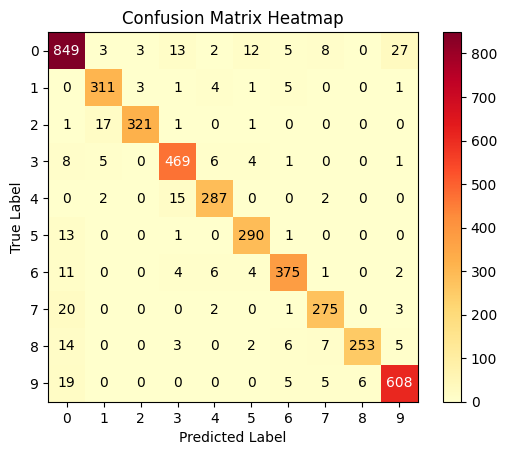

In [5]:
plt.imshow(confusion_matrix, cmap='YlOrRd')  # 指定颜色映射（colormap）
plt.colorbar()  # 添加颜色条

# 添加标签和标题
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')

# 调整坐标刻度
tick_marks = np.arange(len(confusion_matrix))
plt.xticks(tick_marks)
plt.yticks(tick_marks)

# 显示数值
thresh = confusion_matrix.max() / 2.0  # 阈值用于文本颜色的设置
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        plt.text(j, i, confusion_matrix[i, j], ha='center', va='center',
                 color='white' if confusion_matrix[i, j] > thresh else 'black')

# 显示图形
plt.show()


In [6]:
import pandas as pd
import numpy as np

confusion_matrix = np.array([
    [849, 3, 3, 13, 2, 12, 5, 8, 0, 27],
    [0, 311, 3, 1, 4, 1, 5, 0, 0, 1],
    [1, 17, 321, 1, 0, 1, 0, 0, 0, 0],
    [8, 5, 0, 469, 6, 4, 1, 0, 0, 1],
    [0, 2, 0, 15, 287, 0, 0, 2, 0, 0],
    [13, 0, 0, 1, 0, 290, 1, 0, 0, 0],
    [11, 0, 0, 4, 6, 4, 375, 1, 0, 2],
    [20, 0, 0, 0, 2, 0, 1, 275, 0, 3],
    [14, 0, 0, 3, 0, 2, 6, 7, 253, 5],
    [19, 0, 0, 0, 0, 0, 5, 5, 6, 608]
])

TP = np.diag(confusion_matrix)
FP = np.sum(confusion_matrix, axis=0) - TP
TN = np.sum(confusion_matrix) - (FP + TP + np.sum(confusion_matrix, axis=1))
FN = np.sum(confusion_matrix, axis=1) - TP

accuracy = (TP + TN) / (TP + FP + TN + FN)
recall = TP / (TP + FN)
precision = TP / (TP + FP)
f1_score = 2 * (precision * recall) / (precision + recall)

# 创建表格
data = {
    '准确率 (Accuracy)': accuracy,
    '召回率 (Recall)': recall,
    '精确率 (Precision)': precision,
    'F1 值 (F1 Score)': f1_score
}
index = [f'类别 {i+1}' for i in range(len(confusion_matrix))]
df = pd.DataFrame(data, index=index)

# 打印表格
print(df)


       准确率 (Accuracy)  召回率 (Recall)  精确率 (Precision)  F1 值 (F1 Score)
类别 1         0.954337      0.920824         0.908021         0.914378
类别 2         0.989552      0.953988         0.920118         0.936747
类别 3         0.993516      0.941349         0.981651         0.961078
类别 4         0.983687      0.949393         0.925049         0.937063
类别 5         0.990356      0.937908         0.934853         0.936378
类别 6         0.990349      0.950820         0.923567         0.936995
类别 7         0.986855      0.930521         0.939850         0.935162
类别 8         0.987919      0.913621         0.922819         0.918197
类别 9         0.989456      0.872414         0.976834         0.921676
类别 10        0.980124      0.945568         0.939722         0.942636


In [11]:
model = VGG_with_MobileNet()
model.summary()


2023-06-10 18:20:38.164414: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2023-06-10 18:20:38.189761: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2500000000 Hz
2023-06-10 18:20:38.193891: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1fc9da0 executing computations on platform Host. Devices:
2023-06-10 18:20:38.193912: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2023-06-10 18:20:38.196494: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcuda.so.1
2023-06-10 18:20:38.211807: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-06-10 18:20:38.211828: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "VGG_with_MobileNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 1728        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 224, 224, 64) 1728       